# -  Curso de Verão
# Denise de Oliveira Alves Carneiro
## Poloniex


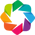

In [69]:
import poloniex
import datetime

import sqlite3 
from sqlalchemy import create_engine 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import holoviews as hv
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh','matplotlib')

## Capturando os dados de um ano para três mercados

In [70]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=int(365))

par1 = 'USDT_BTC'
par2 = 'USDT_ETH' 
par3 = 'USDT_DASH'

In [71]:
market1 = poloniex.get_ohlc(par1, start, end) 
market2 = poloniex.get_ohlc(par2, start, end)
market3 = poloniex.get_ohlc(par3, start, end)

In [33]:
market3.head()

close       high        low       open  quoteVolume  \
date                                                                           
2017-02-03 01:15:00  16.301104  16.301104  16.301104  16.301104     0.000000   
2017-02-03 01:20:00  16.388469  16.388469  16.301104  16.301104     1.833168   
2017-02-03 01:25:00  16.388469  16.388469  16.388469  16.388469     0.000000   
2017-02-03 01:30:00  16.388469  16.388469  16.388469  16.388469     0.000000   
2017-02-03 01:35:00  16.388469  16.388469  16.388469  16.388469     0.000000   

                      volume  weightedAverage  
date                                           
2017-02-03 01:15:00   0.0000        16.301104  
2017-02-03 01:20:00  30.0243        16.378367  
2017-02-03 01:25:00   0.0000        16.388469  
2017-02-03 01:30:00   0.0000        16.388469  
2017-02-03 01:35:00   0.0000        16.388469

In [72]:
#criando conexao com sqlite
conexao = create_engine('sqlite:///banco_projeto.sqlite') 

In [75]:
# banco
market1.to_sql(par1, conexao, if_exists='replace')
market2.to_sql(par2, conexao, if_exists='replace')
market3.to_sql(par3, conexao, if_exists='replace')


In [76]:
conexao.table_names()

['USDT_BTC', 'USDT_DASH', 'USDT_ETH']

In [77]:
USDT_BTC = pd.read_sql(par1, conexao)
USDT_ETH= pd.read_sql(par2, conexao)
USDT_DASH = pd.read_sql(par3, conexao)

USDT_BTC.set_index(['date'],inplace=True)
USDT_ETH.set_index(['date'],inplace=True)
USDT_DASH.set_index(['date'],inplace=True)

## Gráfico 1: Série do preço de abertura das moedas por Mês 

In [78]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    df['date']=df.index
    return hv.Curve(df, ('date', 'Mês/Ano'), ('open', 'Preço de abertura'))

stock_symbols = ['BTC','ETH','DASH']
data = {'BTC': USDT_BTC, 'ETH':USDT_ETH,'DASH':USDT_DASH}
dmap = hv.DynamicMap(load_symbol, kdims='Moeda').redim.values(Moeda=stock_symbols)

In [79]:
%%opts Curve [width=700] {+framewise} (color='black' line_width=1.5)
dmap

:DynamicMap   [Moeda]

## Medidas descritivas para o preço de abertura das moedas

In [80]:
dif = {'moeda 1': USDT_BTC.open.describe(), 'moeda 2': USDT_ETH.open.describe(), 'moeda 3': USDT_DASH.open.describe()}
descritiva = pd.DataFrame(data=dif)
descritiva

moeda 1        moeda 2        moeda 3
count  105120.000000  105120.000000  105120.000000
mean     4996.308305     315.464829     322.832983
std      4529.634252     296.388230     313.936357
min       891.077576      10.492958      15.000000
25%      1591.243853      87.438361      96.370690
50%      2922.654583     286.000000     197.145000
75%      6450.492292     341.491290     352.000000
max     19896.687300    1421.215464    1547.017600

## Gráfico 2: Série do preço de fechamento das moedas por Mês

In [81]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    #df.reset_index(level=0, inplace=True)
    return hv.Curve(df, ('date', 'Mês/Ano'), ('close', 'Preço de fechamento'))

stock_symbols = ['BTC','ETH','DASH']
data = {"BTC": USDT_BTC, 'ETH':USDT_ETH,'DASH':USDT_DASH}
dmap = hv.DynamicMap(load_symbol, kdims='Moeda').redim.values(Moeda=stock_symbols)

In [82]:
%%opts Curve [width=700] {+framewise} (color='red' line_width=1.5)
dmap

:DynamicMap   [Moeda]

## Medidas descritivas para o preço de fechamento das moedas

In [41]:
dif1 = {'moeda 1':  USDT_BTC.close.describe(), 'moeda 2':  USDT_ETH.close.describe(), 'moeda 3':  USDT_DASH.close.describe()}
descritiva1 = pd.DataFrame(data=dif1)
descritiva1

moeda 1        moeda 2        moeda 3
count  105120.000000  105120.000000  105120.000000
mean     4995.729250     315.414337     322.784597
std      4529.189574     296.368279     313.892000
min       891.077576      10.492958      15.460000
25%      1590.299075      87.400000      96.347211
50%      2922.000000     286.000000     197.159999
75%      6450.000000     341.380845     352.000000
max     19896.687300    1422.470000    1548.520200

## Gráfico 3 e 4: Comparando mensalmente os valores médios de abertura e fechamento da moeda

In [83]:
#graficos 
def valor_medio_close(banco):
    dt1 = pd.DataFrame(banco)
    dt1['month'] = dt1.date.dt.to_period('M')
    return dt1.groupby(['month'], sort=False)['close'].mean()

def valor_medio_open(banco):
    dt1 = pd.DataFrame(banco)
    dt1['month'] = dt1.date.dt.to_period('M')
    return dt1.groupby(['month'], sort=False)['open'].mean()

In [84]:
USDT_ETH.head()

close       high        low       open  quoteVolume  \
date                                                                           
2017-02-03 01:40:00  10.731970  10.757335  10.731970  10.757335    26.265407   
2017-02-03 01:45:00  10.742552  10.809998  10.731971  10.809998    75.608063   
2017-02-03 01:50:00  10.731968  10.744060  10.725000  10.744060     2.755863   
2017-02-03 01:55:00  10.731969  10.731969  10.731969  10.731969     0.859323   
2017-02-03 02:00:00  10.725000  10.731970  10.725000  10.731970     0.157036   

                         volume  weightedAverage  
date                                              
2017-02-03 01:40:00  282.000979        10.736593  
2017-02-03 01:45:00  811.537334        10.733476  
2017-02-03 01:50:00   29.587247        10.736109  
2017-02-03 01:55:00    9.222228        10.731969  
2017-02-03 02:00:00    1.684565        10.727285

In [89]:
valores_open = {'open1' :valor_medio_close(USDT_BTC),'open2':valor_medio_close( USDT_DASH),'close1':valor_medio_close(USDT_BTC),'close2':valor_medio_close( USDT_DASH)}

In [91]:
valores_open = pd.DataFrame(valores_open)
valores_open
#valores médios de abertura e fechamento das moedas

close1      close2         open1       open2
month                                                      
2017-02   1065.890260   20.503555   1065.890260   20.503555
2017-03   1132.022788   75.006440   1132.022788   75.006440
2017-04   1253.738163   74.070198   1253.738163   74.070198
2017-05   1889.775954  102.583368   1889.775954  102.583368
2017-06   2567.438083  163.145733   2567.438083  163.145733
2017-07   2481.190876  179.003654   2481.190876  179.003654
2017-08   3831.632214  252.044602   3831.632214  252.044602
2017-09   4078.064697  328.931551   4078.064697  328.931551
2017-10   5290.254249  294.979895   5290.254249  294.979895
2017-11   7735.977852  434.443294   7735.977852  434.443294
2017-12  14704.871657  942.523296  14704.871657  942.523296
2018-01  12860.908061  928.601498  12860.908061  928.601498
2018-02   9165.382303  608.773603   9165.382303  608.773603

In [92]:
%%opts Curve (color='red' line_width=1.5)
%%opts Curve.open2(color='green' line_width=1.5)
%%opts Overlay [width=450 legend_position='top_left']
curve1 = hv.Curve(valores_open.open1,('M','Mês') , 'open',group='open1', label=par1)
curve2 = hv.Curve(valores_open.open2, ('M','Mês'), 'open',group='open2',label=par2)

curve3=curve1*curve2

In [93]:
%%opts Curve (color='red' line_width=1.5)
%%opts Curve.open2(color='green' line_width=1.5)
%%opts Overlay [width=450 legend_position='top_left']
curve1 = hv.Curve(valores_open.close1, ('M','Mês') , 'open',group='open1', label=par1)
curve2 = hv.Curve(valores_open.close2, ('M','Mês'), 'open',group='open2',label=par2)

curve4 = curve1*curve2

In [94]:
curve3+curve4

:Layout
   .Overlay.I  :Overlay
      .Open1.USDT_BTC :Curve   [M]   (open)
      .Open2.USDT_ETH :Curve   [M]   (open)
   .Overlay.II :Overlay
      .Open1.USDT_BTC :Curve   [M]   (open)
      .Open2.USDT_ETH :Curve   [M]   (open)

In [124]:
#graficos 
def valor_volume_max(banco):
    dt1 = pd.DataFrame(banco)
    dt1['month'] = dt1.date.dt.to_period('M')
    return dt1.groupby(['month'], sort=False)['volume'].max()


In [125]:
valores_volumes = {'volume1':valor_volume_max(USDT_BTC),'volume2':valor_volume_max( USDT_DASH)}

In [126]:
volume1= pd.DataFrame(valores_volumes)

## Gráfico 5: Volume

In [127]:
%%opts Bars (color='red' line_width=1.5)[width=500 legend_position='top_left']
graf3=hv.Bars(hv.Curve(volume1)) 
graf3

:Bars   [volume1]   (volume2)